In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os

In [2]:
PATH = 'C:/input/cifar10/cifar/'

In [3]:
from tqdm import tqdm
def classify_by_name(path):
    #import shutil
    if os.path.exists(path):
        for i in tqdm(os.listdir(path)): # 增加进度条
            if os.path.isfile(os.path.join(path,i)):
                subname = i.split('.')[0].split('_')[-1]
                if os.path.exists(os.path.join(path,subname)):
                    os.rename(os.path.join(path,i),os.path.join(path,subname,i))
                else:
                    os.mkdir(os.path.join(path,subname))
                    os.rename(os.path.join(path,i),os.path.join(path,subname,i))
    else: print("not a valid folder")       

In [4]:
%time
classify_by_name(os.path.join(PATH,'train'))

Wall time: 0 ns


100%|███████████████████████████████████████| 10/10 [00:00<00:00, 10000.72it/s]


In [5]:
%time
classify_by_name(os.path.join(PATH,'test'))

Wall time: 0 ns


100%|███████████████████████████████████████| 10/10 [00:00<00:00, 10000.72it/s]


In [6]:
from fastai.conv_learner import *
!ls{PATH}
if not os.path.exists("{}train/bird".format(PATH)):
    raise Exception("expecting class subdirs under 'train/' and 'test/'")
!ls {PATH}/train

C:\Users\ac32\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
'lsC:' is not recognized as an internal or external command,
operable program or batch file.


airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck


In [7]:
"{}train/bird".format(PATH)

'C:/input/cifar10/cifar/train/bird'

In [8]:
#classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [9]:
def get_data(sz,bs):
    tfms = tfms_from_stats(stats,sz,aug_tfms=[RandomFlip()],pad=sz//8) # 给定训练集的统计特征，返回训练和校验传输函数
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs) # 封装dataloaders和datasets

In [10]:
bs=256

In [11]:
# Look at data
data = get_data(32,4)

In [12]:
x,y = next(iter(data.trn_dl))

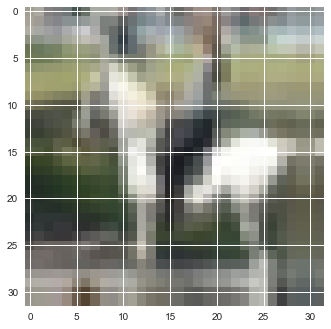

In [13]:
plt.imshow(data.trn_ds.denorm(x)[0])

In [14]:
dir(data)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'aug_dl',
 'bs',
 'c',
 'classes',
 'fix_dl',
 'from_arrays',
 'from_csv',
 'from_dls',
 'from_names_and_array',
 'from_path_and_array',
 'from_paths',
 'get_dl',
 'get_ds',
 'is_multi',
 'is_reg',
 'num_workers',
 'path',
 'resize',
 'resized',
 'sz',
 'test_aug_dl',
 'test_dl',
 'test_ds',
 'trn_dl',
 'trn_ds',
 'trn_y',
 'val_dl',
 'val_ds',
 'val_y']

In [15]:
# fully connection network

In [16]:
date = get_data(32,bs)
lr=1e-2

In [17]:
class SimpleNet(nn.Module): #继承
    def __init__(self,layers): #构造函数
        super().__init__() #调用父类构造函数初始化
        self.layers = nn.ModuleList([nn.Linear(layers[i],layers[i+1]) for i in range(len(layers)-1)]) # # 线性神经网络列表
    
    def forward(self,x): # 输入前向传播
        x = x.view(x.size(0),-1) # reshape,从多维变二维，比如(批量数 × 图片输入像素)
        for l in self.layers: # 对于每一层
            l_x = l(x) # 输入到输出
            x = F.relu(l_x) # 输出激活后，又作为下一层的输入
        return F.log_softmax(l_x,dim=-1) # 最后输出softmax激活而不是relu1, 最后一个维度做softmax
        

In [18]:
learn = ConvLearner.from_model_data(SimpleNet([32*32*3,40,10]), data) # 输入图片32×32*3通道，隐层40个，最后10类

In [19]:
learn, [o.numel() for o in learn.model.parameters()] #每层的参数(w,b)个数

(SimpleNet(
   (layers): ModuleList(
     (0): Linear(in_features=3072, out_features=40, bias=True)
     (1): Linear(in_features=40, out_features=10, bias=True)
   )
 ), [122880, 40, 400, 10])

In [20]:
learn.summary()

OrderedDict([('Linear-1',
              OrderedDict([('input_shape', [-1, 3072]),
                           ('output_shape', [-1, 40]),
                           ('trainable', True),
                           ('nb_params', tensor(122920))])),
             ('Linear-2',
              OrderedDict([('input_shape', [-1, 40]),
                           ('output_shape', [-1, 10]),
                           ('trainable', True),
                           ('nb_params', tensor(410))]))])

In [21]:
learn.lr_find() # 采用周期查找的方式寻找最优学习率, 

 45%|███████████▎             | 5637/12500 [00:22<00:27, 246.08it/s, loss=5.83]

In [22]:
?learn.lr_find()

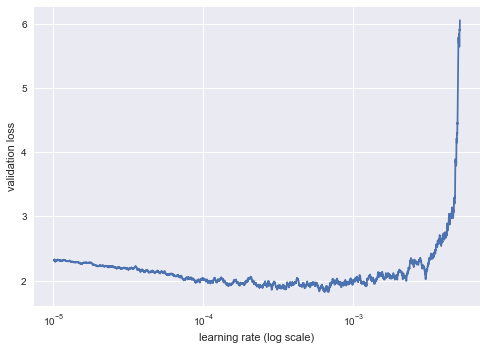

In [23]:
learn.sched.plot()

In [24]:
%time learn.fit(lr,2)

  9%|█▉                   | 1117/12500 [00:04<00:43, 260.01it/s, loss=2.94e+28]
epoch      trn_loss   val_loss   accuracy   
    0      nan        nan        0.1       
    1      nan        nan        0.1       

Wall time: 2min 4s


[nan, 0.1]

In [25]:
%time learn.fit(lr, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      nan        nan        0.1       
    1      nan        nan        0.1       

Wall time: 2min 3s


[nan, 0.1]

In [26]:
# CNN

In [27]:
class ConvNet(nn.Module):
    def __init__(self,layers,c):
        super().__init__()
        self.layers = nn.ModuleList([
                nn.Conv2d(layers[i], layers[i+1], kernel_size=3, stride=2)
                for i in range(len(layers) - 1)]) #卷积层
        self.pool = nn.AdaptiveMaxPool2d(1) # 采用最大池化,输出1×1？
        self.out = nn.Linear(layers[-1], c) # 最后输出是最后一层的输出->分类c的线性
    
    def forward(self,x):
        for l in self.layers: x = F.relu(l(x)) # 输入x，经过层l,再relu激励，然后结果作为输入到下一层
        x = self.pool(x) # 最后pool
        x = x.view(x.size(0),-1) # size(0)表示最初多少个样本，
        return F.log_softmax(self.out(x), dim=-1) # -1*10，最后一个维度softmax
    

In [28]:
learn = ConvLearner.from_model_data(ConvNet([3, 20, 40, 80], 10), data) # 4层网络,颜色通道在前，最终10个分类

In [29]:
len(x), x[0].shape # 一批4个图片

(4, torch.Size([3, 32, 32]))

In [30]:
learn.summary() #，3*32*32->20*15*15->40*7*7->80*3*3->80*1*1(最大池化输出1×1)->10(最终softmax成10类)

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 15, 15]),
                           ('trainable', True),
                           ('nb_params', tensor(560))])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 20, 15, 15]),
                           ('output_shape', [-1, 40, 7, 7]),
                           ('trainable', True),
                           ('nb_params', tensor(7240))])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 40, 7, 7]),
                           ('output_shape', [-1, 80, 3, 3]),
                           ('trainable', True),
                           ('nb_params', tensor(28880))])),
             ('AdaptiveMaxPool2d-4',
              OrderedDict([('input_shape', [-1, 80, 3, 3]),
                           ('output_shape', [-1, 80, 1, 1]),
                           ('nb_params', 0)])),
             ('Linear-5',
 

In [31]:
learn.lr_find(end_lr=100)

 58%|██████████████▌          | 7266/12500 [00:40<00:29, 178.65it/s, loss=2.39]

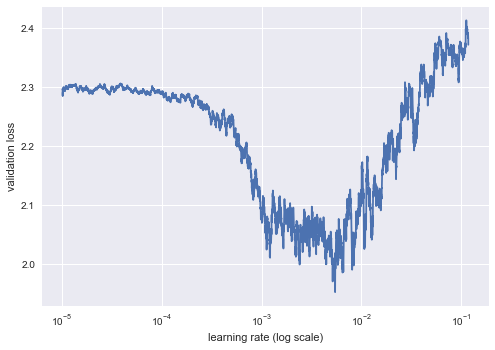

In [32]:
learn.sched.plot()

In [33]:
?learn.shced.plot()

Object `learn.shced.plot` not found.


In [34]:
%time learn.fit(1e-1,2)

  9%|██▏                      | 1110/12500 [00:06<01:09, 163.57it/s, loss=2.38]
epoch      trn_loss   val_loss   accuracy   
    0      2.337183   2.400562   0.1       
    1      2.360883   2.337923   0.1       

Wall time: 3min 6s


[2.33792268037796, 0.1]

In [35]:
%time learn.fit(1e-1, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      2.303806   2.303316   0.1       
    1      2.304504   2.303116   0.1       
    2      2.300223   2.303495   0.1       
    3      2.303647   2.303124   0.1       

Wall time: 5min 50s


[2.303124213218689, 0.1]

In [36]:
# Refactored

In [44]:
class ConvLayer(nn.Module):
    def __init__(self,ni,nf):
        super().__init__()
        self.conv = nn.Conv2d(ni,nf,kernel_size=3,stride=2,padding=1) # 一层卷积
    
    def forward(self,x): return F.relu(self.conv(x)) # 前向传播

In [45]:
class ConvNet2(nn.Module):
    def __init__(self,layers, c):
        super().__init__()
        self.layers = nn.ModuleList([ConvLayer(layers[i],layers[i+1]) for i in range(len(layers)-1)]) # 卷积层
        self.out = nn.Linear(layers[-1], c)
    
    def forward(self,x):
        for l in self.layers: x = l(x) # 卷积层的前向传播
        x = F.adaptive_max_pool2d(x,1) # 最后池化
        x = x.view(x.size(0),-1)
        return F.log_softmax(self.out(x), dim=-1)
        

In [46]:
learn = ConvLearner.from_model_data(ConvNet2([3,20,40,80],10),data)

In [47]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', tensor(560))])),
             ('ConvLayer-2',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', tensor(7240))])),
             ('ConvLayer-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 40, 8, 8]),
 

In [48]:
%time learn.fit(1e-1,2)

epoch      trn_loss   val_loss   accuracy   
    0      2.35913    2.34259    0.1       
    1      2.341644   2.370361   0.1       

Wall time: 4min 59s


[2.370361363887787, 0.1]

In [49]:
%time learn.fit(1e-1, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      2.301682   2.302834   0.1       
    1      2.308309   2.303296   0.1       

Wall time: 3min 22s


[2.303296160697937, 0.1]

In [50]:
# BatchNorm

In [51]:
class BnLayer(nn.Module): # 一层卷积一次Batch Normalize
    def __init__(self,ni,nf,stride=2,kernel_size=3): # ni:输入通道，nf:输出通道
        super().__init__()
        self.conv = nn.Conv2d(ni,nf,kernel_size=kernel_size,stride=stride,bias=False,padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1)) # nf针对通道,
        self.m = nn.Parameter(torch.ones(nf,1,1)) # nf针对通道
    
    def forward(self,x):
        x = F.relu(self.conv(x)) # 前面的卷积层激活
        # transpose转置，contiguous调整元素顺序，view是reshape
        x_chan = x.transpose(0,1).contiguous().view(x.size(1),-1) # 结果shape是(3*-1)
        if self.training:
            # x_chan(3*-1)->mean(1)每个通道的均值(3)->[3,1,1]
            self.means = x_chan.mean(1)[:,None,None] # None增加维度，比如(3,2)经过[:,None,None]->(3,1,1,2)
            self.stds = x_chan.std(1)[:,None,None] # 结果[3,1,1]
        return (x-self.means) / self.stds * self.m + self.a # x是(-1*3*h*w)，每个样本先标准化(减去均值，除以标准差)，再乘m和增加偏差
    

In [52]:
class ConvBnNet(nn.Module):
    def __init__(self,layers,c):
        super().__init__()
        self.conv1 = nn.Conv2d(3,10,kernel_size=5, stride=1, padding=2) #第一层卷积，padding一个边缘增加2
        self.layers = nn.ModuleList([BnLayer(layers[i],layers[i+1]) for i in range(len(layers)-1)])
        self.out = nn.Linear(layers[-1],c)
    
    def forward(self,x):
        x = self.conv1(x)
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x,1)
        x = x.view(x.size(0),-1)
        return F.log_softmax(self.out(x),dim=-1)

In [53]:
learn = ConvLearner.from_model_data(ConvBnNet([10, 20, 40, 80, 160], 10), data)

In [54]:
len(x),type(x),len(x[0]),type(x[0]),x[0].shape # 一批4个样本，一个样本3个维度，

(4, torch.Tensor, 3, torch.Tensor, torch.Size([3, 32, 32]))

In [55]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', tensor(760))])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', tensor(1800))])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', tensor(7200))])),
             ('BnLayer-5',
   

In [56]:
%time learn.fit(3e-2, 2)

epoch      trn_loss   val_loss   accuracy   
    0      nan        nan        0.1       
    1      nan        nan        0.1       

Wall time: 7min 43s


[nan, 0.1]

In [57]:
%time learn.fit(1e-1, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      nan        nan        0.1       
    1      nan        nan        0.1       
    2      nan        nan        0.1       
    3      nan        nan        0.1       

Wall time: 15min 2s


[nan, 0.1]

In [58]:
# Deep BatchNorm

In [59]:
class ConvBnNet2(nn.Module):
    def __init__(self,layers,c):
        super().__init__()
        self.conv1 = nn.Conv2d(3,10,kernel_size=5,stride=1,padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i],layers[i+1]) for i in range(len(layers)-1)])
        #并行的网络,注意前后输入维度对因
        #self.layers2 = nn.ModuleList([BnLayer(layers[i],layers[i+1], 1) for i in range(len(layers)-1)]) 
        # (layers[i+1],layers[i+1], 1)：1代表stride
        self.layers2 = nn.ModuleList([BnLayer(layers[i+1],layers[i+1], 1) for i in range(len(layers)-1)])
        self.out = nn.Linear(layers[-1],c)
    
    def forward(self,x):
        x = self.conv1(x)
        for l,l2 in zip(self.layers, self.layers2): # zip配对
            x = l(x)
            x = l2(x)
        x = F.adaptive_max_pool2d(x,1)
        x = x.view(x.size(0),-1) # (BatchSize * -1)
        return F.log_softmax(self.out(x),dim=-1) #(-> bs*c)
        

In [60]:
learn = ConvLearner.from_model_data(ConvBnNet2([10, 20, 40, 80, 160], 10), data)

In [61]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', tensor(760))])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', tensor(1800))])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', tensor(3600))])),
             ('BnLayer-5',
 

In [62]:
%time learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy   
    0      nan        nan        0.1       
    1      nan        nan        0.1       

Wall time: 14min 24s


[nan, 0.1]

In [63]:
%time learn.fit(1e-2, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      nan        nan        0.1       
    1      nan        nan        0.1       

Wall time: 14min 23s


[nan, 0.1]

In [64]:
# Resnet

In [65]:
class ResnetLayer(BnLayer):
    def forward(self,x): return x + super().forward(x) # x+x(正则化)

In [66]:
class Resnet(nn.Module):
    def __init__(self,layers,c):
        super().__init__()
        self.conv1 = nn.Conv2d(3,10,kernel_size=5, stride=1,padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i],layers[i+1])
            for i in range(len(layers) -1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1],layers[i+1],1)
            for i in range(len(layers) -1)]) # stride=1,这样可以保持输入输出相同
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1],layers[i+1],1)
            for i in range(len(layers) -1)])
        self.out = nn.Linear(layers[-1],c)
    
    def forward(self,x):
        x = self.conv1(x)
        for l1,l2,l3 in zip(self.layers,self.layers2,self.layers3):
            x = l3(l2(l1(x)))
        x = F.adaptive_max_pool2d(x,1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [67]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 10), data)

In [68]:
wd=1e-5

In [69]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', tensor(760))])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', tensor(1800))])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', tensor(3600))])),
             ('ResnetLayer-5

In [70]:
%time learn.fit(1e-2, 2, wds=wd)

epoch      trn_loss   val_loss   accuracy   
    0      nan        nan        0.1       
    1      nan        nan        0.1       

Wall time: 21min 54s


[nan, 0.1]

In [71]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy   
    0      nan        nan        0.1       
    1      nan        nan        0.1       
    2      nan        nan        0.1       
    3      nan        nan        0.1       
    4      nan        nan        0.1       
    5      nan        nan        0.1       
    6      nan        nan        0.1       

Wall time: 1h 17min 5s


[nan, 0.1]

In [72]:
# Resnet2

In [73]:
class Resnet2(nn.Module):
    def __init__(self,layers,c,p=0.5):
        super().__init__()
        self.conv1 = BnLayer(3,16,stride=1,kernel_size=3)
        self.layers = nn.ModuleList([BnLayer(layers[i],layers[i+1])
            for i in range(len(layers)-1)])
        self.layer2 = nn.ModuleList([BnLayer(layers[i+1],layers[i+1],1)
            for i in range(len(layers)-1)])
        self.layer3 = nn.ModuleList([BnLayer(layers[i+1],layers[i+1],1)
            for i in range(len(layers)-1)])
        self.out = nn.Linear(layers[-1],c)
        self.drop = nn.Dropout(p)
    
    def forward(self,x):
        x = self.conv1(x)
        for l1,l2,l3 in zip(self.layers,self.layers2,self.layers3):
            x = l3(l2(l1(x)))
        x = F.adaptive_max_pool2d(x,1)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return F.log_softmax(self.out(x),dim=-1)

In [74]:
learn = ConvLearner.from_model_data(Resnet2([16, 32, 64, 128, 256], 10, 0.2), data)

In [75]:
wd=1e-6

In [76]:
%time learn.fit(1e-2, 2, wds=wd)

  0%|                                                | 0/12500 [00:00<?, ?it/s]


AttributeError: 'Resnet2' object has no attribute 'layers2'

In [ ]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

In [ ]:
learn.save('tmp3')

In [ ]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)

In [ ]:
metrics.log_loss(y,preds), accuracy_np(preds,y)